In [119]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Sequential
import tensorflow as tf
import utils.data
from utils.layers import Encoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [120]:
data = utils.data.get_dataset(mode='mel')

In [121]:
data_length = len(data["mfcc"])
train_ratio = 0.7
valid_ratio = 0.2
test_ratio = 0.1

X_train = []
Y_train = []
X_valid = []
Y_valid = []
X_test = []
Y_test = []

for i in range(len(data["mapping"])):
    data_length = data["labels"].count(i)
    start = data["labels"].index(i)
    train_size = int(train_ratio*data_length)
    valid_size = int(valid_ratio*data_length)
    test_size = int(test_ratio*data_length)

    for element in data["mfcc"][start:start+train_size]:
        X_train.append(element)
    for element in data["labels"][start:start+train_size]:
        Y_train.append(element)
    for element in data["mfcc"][start+train_size:start+train_size+valid_size]:
        X_valid.append(element)
    for element in data["labels"][start+train_size:start+train_size+valid_size]:
        Y_valid.append(element)
    for element in data["mfcc"][start+train_size+valid_size:start+train_size+valid_size+test_size]:
        X_test.append(element)
    for element in data["labels"][start+train_size+valid_size:start+train_size+valid_size+test_size]:
        Y_test.append(element)

In [122]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_valid=np.array(X_valid)
Y_valid=np.array(Y_valid)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

In [123]:
X_train.shape

(6989, 130, 100)

In [124]:
X_train = tf.expand_dims(X_train, axis=-1)
X_valid = tf.expand_dims(X_valid, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)

In [125]:
Y_train = to_categorical(Y_train)
Y_valid = to_categorical(Y_valid)
Y_test  = to_categorical(Y_test)

In [126]:
# Using the functional API to build a model
input = Input(shape=(X_train.shape[1:]))
conv1 = Conv2D(filters=256, kernel_size=3, activation='relu', padding='valid', kernel_initializer='glorot_normal')(input)
conv2 = Conv2D(filters=256, kernel_size=3, activation='relu', padding='valid', kernel_initializer='glorot_normal')(conv1)
# Pooling layer to reduce the dimensionality of the output (downsampling)
ap = AveragePooling2D(pool_size=3, strides=2, padding='same')(conv2)
# Batch normalization to normalize the activations of the previous layer at each batch
ap = BatchNormalization()(ap)
conv3 = Conv2D(filters=256, kernel_size=3, activation='relu', padding='valid', kernel_initializer='glorot_normal')(ap)
ap = AveragePooling2D(pool_size=3, strides=2, padding='same')(conv3)
ap = BatchNormalization()(ap)
conv4 = Conv2D(filters=128, kernel_size=4, activation='relu', padding='valid', kernel_initializer='glorot_normal')(ap)
# Global average pooling to reduce the dimensionality of the output (no parameters to learn)
ap = GlobalAveragePooling2D()(conv4)
dense1 = Dense(256, activation='relu')(ap)
dense1 = Dropout(0.1)(dense1)
dense2 = Dense(128, activation='relu')(dense1)
# Output layer with softmax activation
output = Dense(len(data["mapping"]), activation='softmax')(dense2)
conv_model = tf.keras.Model(inputs=input, outputs=output)


In [127]:
conv_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 130, 100, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 98, 256)      2560      
                                                                 
 conv2d_5 (Conv2D)           (None, 126, 96, 256)      590080    
                                                                 
 average_pooling2d_2 (Averag  (None, 63, 48, 256)      0         
 ePooling2D)                                                     
                                                                 
 batch_normalization_2 (Batc  (None, 63, 48, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 61, 46, 256)       5900

In [128]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=5, restore_best_weights=True)

In [129]:
conv_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
conv_model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_valid, Y_valid), verbose=1, callbacks=es)

32/32 [==============================] - 2s 41ms/step
              precision    recall  f1-score   support

           0       0.49      0.25      0.33       100
           1       0.89      0.66      0.76        99
           2       0.52      0.93      0.66        99
           3       0.74      0.91      0.82        99
           4       0.95      0.73      0.82        99
           5       0.53      0.67      0.59        99
           6       0.59      0.82      0.69       100
           7       0.99      0.90      0.94       100
           8       0.65      0.70      0.68       100
           9       0.23      0.08      0.12       100

    accuracy                           0.66       995
   macro avg       0.66      0.66      0.64       995
weighted avg       0.66      0.66      0.64       995



<Axes: >

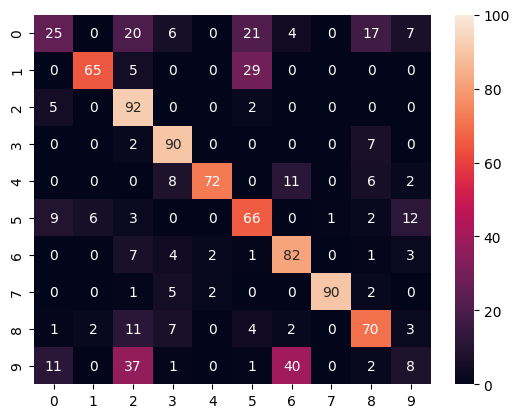

In [ ]:
preds = conv_model.predict(X_test)
print(classification_report(np.argmax(Y_test,1),np.argmax(preds,1)))
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)

In [ ]:
for i in range(len(data["mapping"])):
    print(str(i)+"\t"+data["mapping"][i])

In [ ]:
conv_model.save('./models/conv.h5')

In [ ]:
import librosa
from utils.data import *

In [131]:
conv_model.load_weights('./models/conv3.h5')

In [159]:
def predict_genre(signal, sr=22050, threshold=0.7):
    segments = []
    n_segments = signal.shape[0] // samples_per_segment
    intro = 0
    outro = n_segments
    if n_segments > 20:
        intro = int(n_segments * 0.2)
        outro = n_segments - int(n_segments * 0.2)
    for i in range(intro, outro):
        # calculating start and finish index of the segment
        start = samples_per_segment * i
        end = start + samples_per_segment
        # Calculating the mfcc of the segment
        feature = librosa.feature.melspectrogram(y=signal[start:end], sr=sr, n_mels=n_mfcc_mel, n_fft=n_fft, hop_length=hop_length)
        feature = (librosa.power_to_db(feature, ref=np.max) + 40) / 40
        feature = feature.T.tolist()
        if len(feature) == num_mfcc_vectors_per_segment:
            # Adding the mfcc and label to our data
            segments.append(feature)

    segments = np.array(segments)
    aggr = np.zeros(10)
    for segment in segments:
        segment = tf.expand_dims(segment, axis=-1)
        segment = tf.expand_dims(segment, axis=0)
        p = conv_model.predict(segment, verbose=0)
        if max(p[0]) > threshold:
            aggr += p[0] / np.sum(p[0])
    aggr /= np.sum(aggr)
    pred = np.argmax(aggr)

    print(data["mapping"][pred] + "\t" + str(aggr[np.argmax(aggr)] * 100) + "%")

In [160]:
signal, sr = librosa.load('./demo/Symphony-no.-40-in-G-minor-K.-550-I.-Molto-Allegro.mp3')
predict_genre(signal, sr)

classical	96.60306981471089%


In [169]:
signal, sr = librosa.load('./demo/take-five.mp3')
predict_genre(signal, sr)

jazz	86.8808906330479%


In [170]:
signal, sr = librosa.load('./demo/The Offspring - You\'re Gonna Go Far, Kid (128 kbps).mp3')
predict_genre(signal, sr)

rock	36.07794401194706%


In [168]:
signal, sr = librosa.load('./demo/AWS - Viszlát nyár(128 kbps).mp3')
predict_genre(signal, sr)

pop	43.470345823025205%


In [167]:
signal, sr = librosa.load('./demo/AC_DC - Highway to Hell (128 kbps).mp3')
predict_genre(signal, sr)

rock	37.75902891545634%


In [166]:
signal, sr = librosa.load('./demo/Slipknot - Psychosocia (128 kbps).mp3')
predict_genre(signal, sr)

metal	50.25985015451829%


In [165]:
signal, sr = librosa.load('./demo/Rammstein - Du Hast (128 kbps).mp3')
predict_genre(signal, sr)

rock	34.1692380630275%


In [164]:
signal, sr = librosa.load('./demo/Evanescence - Bring Me To Life  (128 kbps).mp3')
predict_genre(signal, sr)

country	62.01548155939985%


In [163]:
signal, sr = librosa.load('./demo/Road of Resistance (128 kbps).mp3')
predict_genre(signal, sr)

metal	57.85377619138058%


In [197]:
import os
import pytube
import warnings
warnings.filterwarnings("ignore")

In [203]:
def predict_from_youtube_link(link):
    yt = pytube.YouTube(link)
    video = yt.streams.filter(only_audio=True).first()
  
    # check for destination to save file
    destination = './demo/'
    
    # download the file
    out_file = video.download(output_path=destination)
    
    # save the file
    base, ext = os.path.splitext(out_file)
    new_file = base + '.mp3'
    os.rename(out_file, new_file)
    
    # result of success
    signal, sr = librosa.load(new_file)
    predict_genre(signal, sr)
    os.remove(new_file)

In [206]:
predict_from_youtube_link("https://www.youtube.com/watch?v=69RdQFDuYPI")

reggae	96.50425509341144%


In [207]:
predict_from_youtube_link("https://www.youtube.com/watch?v=Wn-VdZ4LEKg")

metal	52.159262904372184%


In [208]:
predict_from_youtube_link("https://www.youtube.com/watch?v=zL3wWykAKfs")

hiphop	40.924811055708844%


In [209]:
predict_from_youtube_link("https://www.youtube.com/watch?v=Zi_XLOBDo_Y")

blues	nan%


In [211]:
predict_from_youtube_link("https://www.youtube.com/watch?v=9yRme0C2pmI")

rock	55.20892737495229%


In [210]:
predict_from_youtube_link("https://www.youtube.com/watch?v=aWxBrI0g1kE")

rock	62.130191326199025%


In [212]:
predict_from_youtube_link("https://www.youtube.com/watch?v=YVkUvmDQ3HY")

hiphop	58.02503363892433%
